In [10]:
#%matplotlib inline
#%matplotlib widget
import torch
import gym
import torch
import gym
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.distributions import Normal
from env.WarthogEnv import WarthogEnv
import scipy.signal
import time
eps = np.finfo(np.float32).eps.item()
#torch.manual_seed(100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [11]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [12]:
class ValueNetwork(nn.Module):
    def __init__(self, obs_dimension, sizes, act = nn.ReLU):
        super(ValueNetwork, self).__init__()
        sizes = [obs_dimension] + sizes + [1]
        out_activation = nn.Identity
        self.layers = []
        for j in range(0,len(sizes) - 1):
            act_l = act if j < len(sizes) -2 else out_activation
            self.layers+=[nn.Linear(sizes[j], sizes[j+1]), act_l()]
        self.v = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.v(x)

In [13]:
class PolicyNetworkCat(nn.Module):
    def __init__(self, obs_dimension, sizes, action_dimension, act= nn.ReLU):
        super(PolicyNetworkCat, self).__init__()
        sizes = [obs_dimension] + sizes + [action_dimension]
        out_activation = nn.Identity
        self.layers = []
        for j in range(0,len(sizes) - 1):
            act_l = act if j < len(sizes) -2 else out_activation
            self.layers+=[nn.Linear(sizes[j], sizes[j+1]), act_l()]
        self.pi = nn.Sequential(*self.layers)
    def forward(self, x):
        score = self.pi(x)
        #probs = F.softmax(score,dim = 1)
        dist = torch.distributions.Categorical(logits=score)
        return dist

In [14]:
class PolicyNetworkGauss(nn.Module):
    def __init__(self, obs_dimension, sizes, action_dimension,act = nn.ReLU):
        super(PolicyNetworkGauss, self).__init__()
        sizes = [obs_dimension] + sizes + [action_dimension]
        out_activation = nn.Identity
        self.layers = []
        for j in range(0,len(sizes) - 1):
            act_l = act if j < len(sizes) -2 else out_activation
            self.layers+=[nn.Linear(sizes[j], sizes[j+1]), act_l()]
        self.mu = nn.Sequential(*self.layers)
        log_std = -0.5*np.ones(action_dimension, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std), requires_grad=True)
    def forward(self, x):
        mean = self.mu(x)
        std = torch.exp(self.log_std)
        dist = Normal(mean, std)
        return dist

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
1
Normal(loc: torch.Size([1, 2]), scale: torch.Size([1, 2]))
tensor([[-0.7730, -0.5515]], grad_fn=<SubBackward0>)
tensor([[-0.0104, -0.0123]], grad_fn=<AddmmBackward0>)


/home/akhil/anaconda3/envs/ppo/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


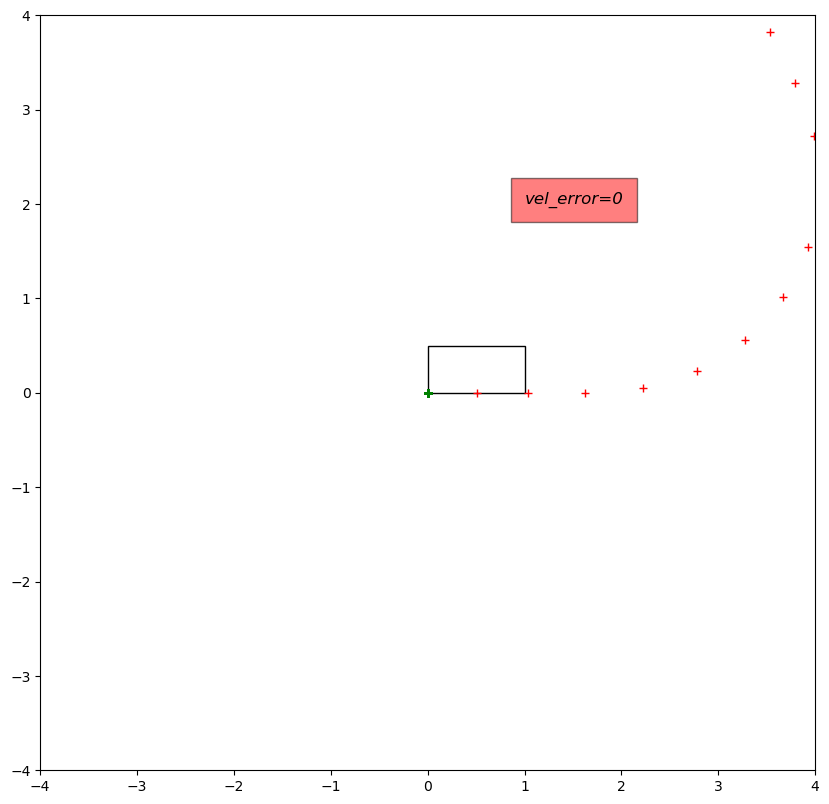

In [15]:
#env = gym.make('CartPole-v1')
#env = gym.make('CartPole-v1')
env = WarthogEnv('sim_remote_waypoint.txt', None)
sizes = [128]
obs_dimension = env.observation_space.shape
action_dimension = env.action_space.shape
pi = PolicyNetworkGauss(*obs_dimension, sizes, *action_dimension)
o = torch.zeros(1,42)
a = torch.as_tensor([0.5, 0.3], dtype=torch.float32)
print(o)
m = pi(o)
logp = m.log_prob(a)
print(len(a.shape))
print(m)
print(logp)
print(m.loc)

In [16]:
class PPOBuffer:
    """
    A buffer for storing trajectories experienced by a PPO agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        #self.act_buf = np.zeros((size,), dtype=np.float32)
        self.act_buf = np.zeros((size,act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.

        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
       # print(rews)
       # print(vals)
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick

        self.adv_buf = (self.adv_buf - self.adv_buf.mean()) / (self.adv_buf.std()+eps)
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}


In [17]:
def ppo(env, seed = 0, steps = 128, buff_size = 4, train_time_steps = 10000000, gamma = 0.99, clip_ratio = 0.2, lr_pi = 3e-5, 
        lr_vf = 1e-3, pi_train_itrs = 4, v_train_itrs = 4, lam = 0.97, max_ep_len = 500):
        obs_dim = env.observation_space.shape
        #action_dim = 2
        action_dim = env.action_space.shape
        h_sizes = [64,64]
        vi = ValueNetwork(*obs_dim, h_sizes, act=nn.Tanh).to(device)
        #pi = PolicyNetworkCat(*obs_dim, h_sizes, action_dim).to(device)
        pi = PolicyNetworkGauss(*obs_dim, h_sizes, *action_dim,act=nn.Tanh).to(device)
        data_buff = PPOBuffer(*obs_dim, *action_dim, steps)
        policy_opt = optim.Adam(pi.parameters(), lr = lr_pi)
        value_opt = optim.Adam(vi.parameters(), lr = lr_vf)
        obs = env.reset()
        curr_time_step = 0
        pbar = tqdm(total = train_time_steps)
        num_episode = 0
        ep_rewards = [0]
        ep_steps = [0]
        start_time = time.time()
        while curr_time_step < train_time_steps: 
                for t in range(0, steps):
                        curr_time_step+=1
                        with torch.no_grad():
                                m = pi(torch.as_tensor(obs, dtype=torch.float32).to(device))
                                action = m.sample()
                                #print(action)
                                action = action.reshape((-1,) + action_dim)
                                #print(action)
                                logp = m.log_prob(action).sum(dim=1)
                               # print(logp)
                                action = action.cpu().numpy() 
                                clipped_action = np.clip(action, env.action_space.low, env.action_space.high)
                                #print(clipped_action)
                                #obs_new, rew, done, _ = env.step(a.item())
                                obs_new, rew, done, _ = env.step(clipped_action[0])
                                ep_rewards[num_episode]+=rew 
                                ep_steps[num_episode]+=1
                                v = vi(torch.as_tensor(obs, dtype=torch.float32).to(device))
                        data_buff.store(obs, action, rew, v.cpu().numpy(), logp.cpu().numpy())
                        obs = obs_new
                        if done or t == steps-1:
                                if done:
                                        v_ = 0.
                                        obs = env.reset()
                                        done = False
                                        num_episode+=1
                                        ep_rewards.append(0)
                                        ep_steps.append(0)
                                        curr_time = time.time()
                                        if num_episode %100 == 0:
                                                print(f'episode: {num_episode-1} \t episode_reward: {np.mean(ep_rewards[-10:-2])} \t total steps:{curr_time_step}\t fps"{curr_time_step/(curr_time-start_time)}\t avg_ep_steps: {np.mean(ep_steps[-10:-2])}')
                                else:
                                        v_ = vi(torch.as_tensor(obs, dtype=torch.float32).to(device))
                                        v_ = v_.detach().cpu().numpy()
                                data_buff.finish_path(v_)
                        if(curr_time_step % 100000 == 0):
                                torch.save(pi, f'./temp_policy/tan_h/manaul_ppo_batch_{curr_time_step}.pt')
                                np.savetxt(f'./temp_policy/tan_h/avg_rew_{curr_time_step}', ep_rewards, fmt='%f')

                        #curr_time_step+=1
                      #  pbar.update(1)
                data = data_buff.get()
                ret, act, adv, o, logp_old= data['ret'].to(device), data['act'].to(device), data['adv'].to(device), data['obs'].to(device), data['logp'].to(device)
                for j in range(0, pi_train_itrs):
                        indices = np.random.permutation(steps)
                        start_idx = 0
                        while start_idx < steps:
                                batch_ind = indices[start_idx: start_idx+buff_size]
                                ret_b = ret[batch_ind]
                                act_b = act[batch_ind]
                                adv_b = adv[batch_ind]
                                o_b = o[batch_ind]
                           #     o_b_v = o[batch_ind]
                                logp_old_b = logp_old[batch_ind]
                                act_dist = pi(o_b)
                                logp = act_dist.log_prob(act_b).sum(dim=1)
                                ratio = torch.exp(logp - logp_old_b)
                                clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv_b
                                loss_pi = -(torch.min(ratio * adv_b, clip_adv)).mean()
                                loss_pi.backward()
                                policy_opt.step()
                                value_opt.zero_grad()
                       # ret, ob = data['ret'], data['obs']
                                val = vi(o_b)
                                value_loss = F.mse_loss(val.flatten(), ret_b)
                                value_loss.backward()
                                value_opt.step()
                                start_idx = start_idx+buff_size
                                print(ret_b)
                                print(act_b)
                                print(adv_b)
                                print(o_b)
                                print(logp_old_b)
                        if j==2:
                                return pi
                '''for j in range(0, pi_train_itrs):
                        act_dist = pi(o)
                        logp = act_dist.log_prob(act).sum(dim=1)
                        ratio = torch.exp(logp - logp_old)
                        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
                        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
                        loss_pi.backward()
                        policy_opt.step()
                for i in range (0, v_train_itrs):
                        value_opt.zero_grad()
                       # ret, ob = data['ret'], data['obs']
                        val = vi(o)
                        value_loss = F.mse_loss(val.flatten(), ret)
                        value_loss.backward()
                        value_opt.step()'''
                #pbar.update(1)
        pbar.close()
        return pi



In [18]:
#python.dataScience.textOutputLimit = 0
pi = ppo(env)


tensor([ 19.5307,   3.6115,  28.7054, -10.4790])
tensor([[-0.2945, -1.3024],
        [ 0.6555,  1.1189],
        [ 0.2472,  0.3712],
        [ 0.0388,  0.8990]])
tensor([ 1.4880,  0.1392,  1.8984, -1.2066])
tensor([[ 0.1967, -1.8741, -0.0910,  0.7822,  0.5282, -0.4636, -0.0932,  0.7822,
          1.0564, -0.2752, -0.1382,  0.7822,  1.6065, -0.2281, -0.2433,  0.7822,
          2.1631, -0.2320, -0.3728,  0.7822,  2.7180, -0.2609, -0.5037,  0.7822,
          3.2636, -0.3021, -0.6146,  0.7822,  3.7993, -0.3473, -0.6607,  0.7822,
          4.3335, -0.3870, -0.6542,  0.7822,  4.8732, -0.4172, -0.6183,  0.7822,
          0.2178, -0.6241],
        [ 0.2116, -2.8195,  0.4050, -2.3621,  0.3430,  0.4562,  0.2999, -2.3621,
          0.8971,  0.3595,  0.1705, -2.3621,  1.4502,  0.2870,  0.0396, -2.3621,
          1.9972,  0.2183, -0.0714, -2.3621,  2.5378,  0.1554, -0.1175, -2.3621,
          3.0787,  0.1065, -0.1109, -2.3621,  3.6249,  0.0733, -0.0750, -2.3621,
          4.1780,  0.0536,  0.0145, 

  0%|          | 0/10000000 [00:00<?, ?it/s]

tensor([ 5.3190, -5.3449,  0.0000, 10.0682])
tensor([[-0.0026,  0.5576],
        [ 0.2172,  0.2600],
        [ 0.3954,  1.0531],
        [ 0.1691,  0.2905]])
tensor([ 0.0682, -0.2947, -0.4856,  0.5711])
tensor([[ 0.2715, -0.0899,  0.2043, -0.2999,  0.8170,  0.1078,  0.0992, -0.2999,
          1.3737,  0.1043, -0.0302, -0.2999,  1.9294,  0.0654, -0.1612, -0.2999,
          2.4776,  0.0147, -0.2721, -0.2999,  3.0178, -0.0377, -0.3182, -0.2999,
          3.5572, -0.0811, -0.3116, -0.2999,  4.1018, -0.1122, -0.2758, -0.2999,
          4.6536, -0.1317, -0.1862, -0.2999,  5.2105, -0.1376, -0.0489, -0.2999,
          1.2999,  2.0076],
        [ 0.5803,  1.6604,  0.1680,  0.1455,  0.8366,  0.9316,  0.1219,  0.1455,
          1.2865,  0.6122,  0.1285,  0.1455,  1.7986,  0.4676,  0.1643,  0.1455,
          2.3375,  0.3962,  0.2539,  0.1455,  2.8905,  0.3688,  0.3912,  0.1455,
          3.4478,  0.3724,  0.5583,  0.1455,  3.9968,  0.3982,  0.7466,  0.1455,
          4.5255,  0.4403,  0.9472,  0.1

In [19]:
#env.clear()

#%matplotlib widget
#env = WarthogEnv('sim_remote_waypoint.txt', None)
#pi = torch.load("./temp_warthog.pt")
#plt.ion()
#plt.pause(2)
#obs = env.reset()
#for i in range(0,400):
#    m = pi(torch.as_tensor(obs, dtype=torch.float32).to(device))
#    action = m.sample()
#    obs, rew, done, info = env.step(action.cpu().numpy())
#    env.render()
#    if done:
#        obs = env.reset()


In [20]:
#torch.save(pi,"temp_warthog.pt")